In [31]:
import torch
from torch import nn
from torch.nn.functional import batch_norm
from torchinfo import summary
import matplotlib.pyplot as plt

In [62]:
cfg = {"test" :
        [64, 64, "M", 128, 128, "M", 256, 256, 256, "M"],
       "test_2":
       [32, 32, "M", 64, 64, "M", 128, 128, "M"]}

In [65]:
class my_VGGnet(nn.Module):
    def __init__(self, cfg, batch_norm = False, num_classes = 10, drop_p = 0.5):
        super().__init__()

        self.features = self.make_layers(cfg, batch_norm)


        self.classifier = nn.Sequential(nn.Linear(128 * 4 * 4, 516),
                                        nn.ReLU(),
                                        nn.Dropout(p = drop_p),
                                        #nn.Linear(512, 512),
                                        #nn.ReLU(),
                                        #nn.Dropout(p = drop_p),
                                        nn.Linear(516, num_classes))


    def make_layers(self, cfg, batch_norm = False):
        layer = []
        in_channels = 3

        for v in cfg:
            if type(v) == int:
                if batch_norm:
                    layer += [nn.Conv2d(in_channels, v, 3, padding=1, bias = False),
                              nn.BatchNorm2d(v),
                              nn.ReLU()]
                else:
                    layer += [nn.Conv2d(in_channels, v, 3, padding = 1),
                              nn.ReLU()]
                in_channels = v
            else:
                layer += [nn.MaxPool2d(2)]

        return nn.Sequential(*layer)

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                       nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


In [64]:
model = my_VGGnet(cfg["test_2"],batch_norm = True)
#model = CNN_deep()
summary(model, input_size=(1,3,32,32), device="mps")

Layer (type:depth-idx)                   Output Shape              Param #
my_VGGnet                                [1, 128, 4, 4]            269,878
├─Sequential: 1-1                        [1, 128, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           864
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 32, 32]           64
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 64, 16, 16]           18,432
│    └─BatchNorm2d: 2-9                  [1, 64, 16, 16]           128
│    └─ReLU: 2-10                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-11                      [1, 64, 16, 16]           36,8

In [34]:
from multiclass_function_2 import *
import torch
from torchvision import datasets, transforms

In [56]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3 # for LR STEP
LR_GAMMA = 0.9 # for LR STEP
EPOCH = 30
TRAIN_RATIO = 0.7
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "VGG_Test"
dataset = "CIFAR10"
save_model_path = f"./result/{model_type}_{dataset}.pt"
save_history_path = f"./result/{model_type}_history_{dataset}.pt"

transform_train = transforms.Compose([
    transforms.ToTensor()])
transform_test = transforms.ToTensor()

In [57]:
train_DS = datasets.CIFAR10(root = '/Users/sanghyun/Desktop/GIT_Folder', train = True, download=False, transform=transform_train)
test_DS = datasets.CIFAR10(root  = '/Users/sanghyun/Desktop/GIT_Folder', train = False, download=False, transform=transform_test)

In [58]:
NoT = int(len(train_DS)*TRAIN_RATIO)
NoV = len(train_DS) - NoT

train_DS, val_DS= torch.utils.data.random_split(train_DS, [NoT, NoV])

val_DS.transform = transform_test # test의 transform 적용!

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True) # 이미지 변형 체크 할땐 False로
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True) # 이미지 변형 체크 할땐 False로

In [66]:
model = my_VGGnet(cfg["test_2"],batch_norm = True).to(DEVICE)
#model = CNN_deep().to(DEVICE)

Epoch: 1, current_LR = 0.002


train loss: 1.73217, val loss: 1.40533 
train acc: 36.6 %, val acc: 47.8 %, time: 6 s
--------------------
Epoch: 2, current_LR = 0.002


train loss: 1.31879, val loss: 1.15612 
train acc: 52.5 %, val acc: 57.9 %, time: 6 s
--------------------
Epoch: 3, current_LR = 0.002


train loss: 1.10392, val loss: 0.9995 
train acc: 60.9 %, val acc: 65.3 %, time: 6 s
--------------------
Epoch: 4, current_LR = 0.002


train loss: 0.95485, val loss: 0.88678 
train acc: 67.0 %, val acc: 69.1 %, time: 6 s
--------------------
Epoch: 5, current_LR = 0.002


train loss: 0.82697, val loss: 0.84582 
train acc: 71.4 %, val acc: 70.5 %, time: 6 s
--------------------
Epoch: 6, current_LR = 0.002


train loss: 0.72241, val loss: 0.75825 
train acc: 75.3 %, val acc: 74.8 %, time: 6 s
--------------------
Epoch: 7, current_LR = 0.002


train loss: 0.64081, val loss: 0.65273 
train acc: 78.3 %, val acc: 77.2 %, time: 6 s
--------------------
Epoch: 8, current_LR = 0.002


train loss: 0.56482, val loss: 0.61373 
train acc: 80.9 %, val acc: 79.1 %, time: 6 s
--------------------
Epoch: 9, current_LR = 0.002


train loss: 0.49872, val loss: 0.61514 
train acc: 83.2 %, val acc: 79.0 %, time: 6 s
--------------------
Epoch: 10, current_LR = 0.002


train loss: 0.42785, val loss: 0.73815 
train acc: 85.5 %, val acc: 76.9 %, time: 6 s
--------------------
Epoch: 11, current_LR = 0.002


train loss: 0.38765, val loss: 0.72496 
train acc: 86.8 %, val acc: 78.7 %, time: 6 s
--------------------
Epoch: 12, current_LR = 0.002


train loss: 0.33717, val loss: 0.63771 
train acc: 88.4 %, val acc: 80.2 %, time: 6 s
--------------------
Epoch: 13, current_LR = 0.002


train loss: 0.29315, val loss: 0.61641 
train acc: 89.8 %, val acc: 81.8 %, time: 6 s
--------------------
Epoch: 14, current_LR = 0.002


train loss: 0.25646, val loss: 0.64937 
train acc: 91.2 %, val acc: 80.3 %, time: 6 s
--------------------
Epoch: 15, current_LR = 0.002


train loss: 0.2268, val loss: 0.73729 
train acc: 92.3 %, val acc: 79.5 %, time: 6 s
--------------------
Epoch: 16, current_LR = 0.002


train loss: 0.20527, val loss: 0.68646 
train acc: 92.9 %, val acc: 80.7 %, time: 6 s
--------------------
Epoch: 17, current_LR = 0.002


train loss: 0.18111, val loss: 0.72179 
train acc: 93.8 %, val acc: 81.5 %, time: 6 s
--------------------
Epoch: 18, current_LR = 0.002


train loss: 0.16577, val loss: 0.76519 
train acc: 94.3 %, val acc: 81.7 %, time: 6 s
--------------------
Epoch: 19, current_LR = 0.002


train loss: 0.15142, val loss: 0.85422 
train acc: 94.8 %, val acc: 80.0 %, time: 6 s
--------------------
Epoch: 20, current_LR = 0.002


train loss: 0.14298, val loss: 0.88765 
train acc: 95.1 %, val acc: 80.1 %, time: 6 s
--------------------
Epoch: 21, current_LR = 0.002


train loss: 0.13077, val loss: 0.83517 
train acc: 95.7 %, val acc: 81.7 %, time: 6 s
--------------------
Epoch: 22, current_LR = 0.002


train loss: 0.12096, val loss: 0.86938 
train acc: 95.9 %, val acc: 80.5 %, time: 6 s
--------------------
Epoch: 23, current_LR = 0.002


train loss: 0.10948, val loss: 0.96774 
train acc: 96.3 %, val acc: 81.3 %, time: 6 s
--------------------
Epoch: 24, current_LR = 0.002


train loss: 0.1148, val loss: 0.89385 
train acc: 96.3 %, val acc: 80.8 %, time: 6 s
--------------------
Epoch: 25, current_LR = 0.002


train loss: 0.10693, val loss: 0.92668 
train acc: 96.5 %, val acc: 82.0 %, time: 6 s
--------------------
Epoch: 26, current_LR = 0.002


train loss: 0.09424, val loss: 0.90401 
train acc: 96.9 %, val acc: 81.6 %, time: 6 s
--------------------
Epoch: 27, current_LR = 0.002


train loss: 0.08733, val loss: 0.99149 
train acc: 97.1 %, val acc: 81.0 %, time: 6 s
--------------------
Epoch: 28, current_LR = 0.002


train loss: 0.09401, val loss: 0.90494 
train acc: 97.0 %, val acc: 81.4 %, time: 6 s
--------------------
Epoch: 29, current_LR = 0.002


train loss: 0.09091, val loss: 0.97671 
train acc: 97.2 %, val acc: 80.8 %, time: 6 s
--------------------
Epoch: 30, current_LR = 0.002


train loss: 0.07826, val loss: 1.03008 
train acc: 97.4 %, val acc: 81.8 %, time: 6 s
--------------------


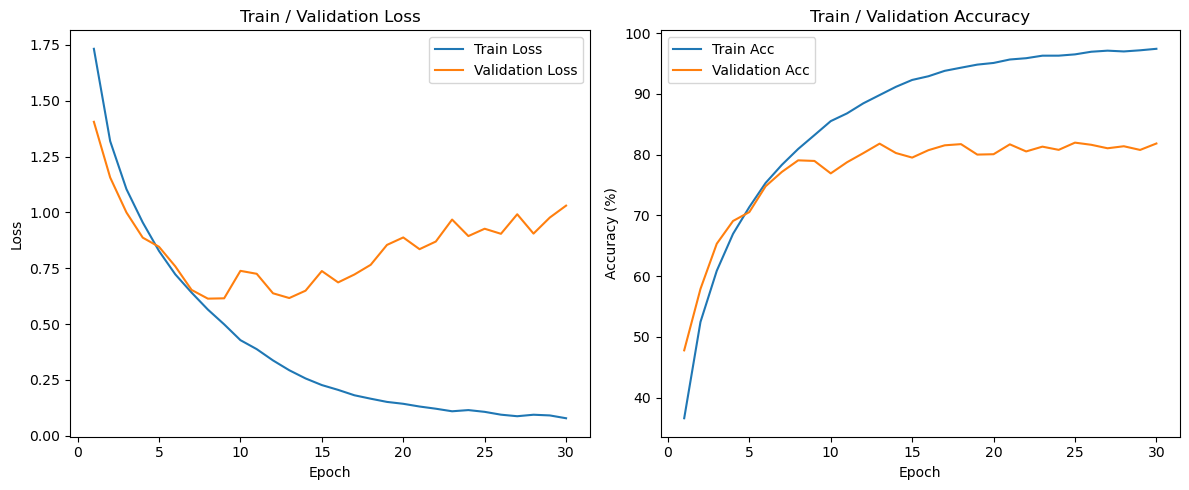

In [67]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # loss_history = Train(model, train_DL, criterion, optimizer, EPOCH, )
    loss_history = Train(model, train_DL, val_DL, criterion, optimizer, EPOCH,
          BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path)

    torch.save(model, save_model_path)

history = torch.load(save_history_path)
loss_history = history["loss_history"]
acc_history = history["acc_history"]

epochs = range(1, len(loss_history["train"]) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history["train"], label='Train Loss')
plt.plot(epochs, loss_history["val"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history["train"], label='Train Acc')
plt.plot(epochs, acc_history["val"], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train / Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
Test(model, test_DL, criterion)


Test loss: 0.91606
Test accuracy: 8392/10000 (83.9 %)


83.9

In [68]:
Test(model, test_DL, criterion)


Test loss: 1.08913
Test accuracy: 8159/10000 (81.6 %)


81.6

In [82]:
Test(model, test_DL, criterion)


Test loss: 1.16485
Test accuracy: 8058/10000 (80.6 %)


80.6

1349910


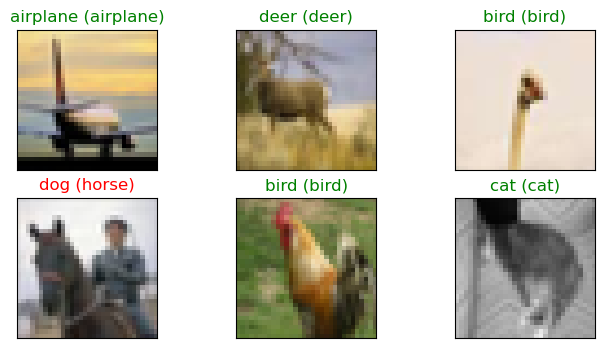

In [71]:
Test_plot(model, test_DL)
print(count_params(model))